# 📚Topic Modeling of News Articles


## Introduction

In this project you will leverage skills that you have learned in the past few weeks, such as topic modeling and latent Dirichlet allocation (LDA), to build a small model analyzing the content of news articles from different sources across the US.

The main learning objectives for this assignment are:
1. Use LDA topic modeling to find patterns in a realistic, noisy, unlabeled text corpus
2. Understand how topic modeling results are influenced by preprocessing and hyperparameters
3. Use dimensionality reduction and clustering algorithms to create effective visualizations of large text data

Note: At some points in the assignment, we'll format some parts of instructions in all-caps. We're not yelling! We just think they're very important details that you need to take note of.  

## Installation and Imports

In [ ]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

# imports for data loading right below
from os.path import exists
import csv
import pickle
from tqdm import tqdm
from spacy.tokens import DocBin

# !python3 -m spacy download en_core_web_sm

from typing import TypeAlias
spacy_doc: TypeAlias = spacy.tokens.doc.Doc

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Data Loading

**Warning**: Loading the data could take as much as 10 minutes when running for the first time. After that, the parsed documents (and news article "locations") are cached and will be reloaded on each successive run (should take about 15 seconds).

In [ ]:
# TODO: Update this to the filepath of your copy of the assignment
FOLDER = "/content/drive/MyDrive/ComputationalLinguistics/assignment2"
FILEPATH = f"{FOLDER}/articles_sampled_data.csv"

In [ ]:
######################
#     LOAD DATA      #
################################################################################################################################
# This cell block will load in the dataset into                                                                                #
#   * spacy_processed_docs - list of spaCy documents (spacy.tokens.doc.Doc) that we can use as data to train our topic model   #
#   * doc_locations - list of states where each document was sourced from (this will be used in Part 3: Visualization)         #
################################################################################################################################
NUM_DOCUMENTS = 5000 # INFO: Feel free to change this to load in less documents for debugging, but otherwise keep it at 5000 to train the topic model
nlp = spacy.load("en_core_web_sm")
DOCS_PATH = f"{FOLDER}/parsed_{NUM_DOCUMENTS}_tweets.spacy"
LOCATIONS_PATH = f"{FOLDER}/doc_locations_{NUM_DOCUMENTS}.pkl"

doc_locations = []
spacy_processed_docs = []

if exists(DOCS_PATH) and exists(LOCATIONS_PATH):
	doc_bin = DocBin().from_disk(DOCS_PATH)
	spacy_processed_docs = list(doc_bin.get_docs(nlp.vocab))

	with open(LOCATIONS_PATH, mode="rb") as f:
		doc_locations = pickle.load(f)
else:
	with open(FILEPATH, encoding="utf-8") as f:
		reader = csv.DictReader(f, delimiter=",")
		for i, row in tqdm(enumerate(reader), total=NUM_DOCUMENTS):
			if i == NUM_DOCUMENTS:
				break
			spacy_processed_docs.append(nlp(row["content"]))
			doc_locations.append(row["location"])

		DocBin(docs=spacy_processed_docs).to_disk(DOCS_PATH)
		with open(LOCATIONS_PATH, "wb") as f:
			pickle.dump(doc_locations, f)

Run this cell to make sure that the data is loaded in correctly. There should be 5000 documents, and you can see an example article from the dataset.

In [ ]:
print(f"Number of documents: {len(spacy_processed_docs)}\n")
print(spacy_processed_docs[0])

Number of documents: 5000

By Special to the Advance

Spain Park’s Sarah Ashlee Barker is the Alabama Sports Writers Association 33rd Miss Basketball and first from Spain Park.

The Georgia signee is also the Gatorade state Player of the Year, the MaxPreps state Player of the Year, the AL.com Player of the Year and the AL.com Birmingham Region Player of the Year.

She has been selected to the Alabama Sports Writers Association All-State team each of the past three seasons and is the two-time Class 7A Player of the Year.

Barker led the Jaguars to their second Class 7A state championship in the past three seasons, averaging 23.3 points, 10.9 rebounds and 2.7 assists this season for coach Mike Chase.

She earned Class 7A tournament MVP this season and was also named all-tournament on Spain Park’s 2018 championship team and 2017 finalist squad.


# Part 1: Basic Topic Model

First, let's train a basic topic model and see what happens! We'll do very basic text preprocessing (tokenization and lowercasing) to start, and we'll use LDA for the topic model.

To start, let's build the following components for topic modeling:

1.  `M`:
    A binary term-document matrix of shape (num_documents, vocab_size)

2.  `word2idx`: A dictionary which maps each word to its (zero-indexed) rank in the vocabulary (e.g. the most frequent word should have rank 0, the second most frequent word rank 1, etc).

3. `idx2word`: The inverse of the above (i.e., mapping from index to word)

You will use `M` to train the topic model directly, and you will use the other two lookup tables in order to analyze the actual topics produced. You should use spaCy to ***TOKENIZE*** and ***LOWERCASE*** the raw text, but not do any additional preprocessing.
When lowercasing, please use `token.lemma_.lower()`

In [ ]:
from collections import Counter # HINT
# plus, keep in mind that we've imported this for later parts of the assignment!

def binary_term_doc_matrix(docs : list[spacy_doc]) -> tuple[np.ndarray[np.float64], dict[int, str]]:
    """
    Preprocess and transform docs to create our binary term-document matrix and dictionaries as described above

    Parameters
    ----------
    docs : list[spacy_doc]
        A list of spaCy processed documents (i.e. each item is the output of nlp(article))

    Returns
    -------
    M : np.ndarray[float]
        A binary term-document matrix, each value in M should be either 0 or 1
    idx2word : dict[int, str]
        A dictionary that maps each index/rank to each word in the vocabulary
    """
    # TODO: You will need to fill in word2idx and idx2word, and then M
    # HINT: Make sure to use token.lemma_.lower() to lowercase text, rather than token.text.lower()
    word2idx = {}
    idx2word = {}
    counter = Counter()
    for doc in docs:
        for token in doc:
            t = token.lemma_.lower()
            counter.update({t:1})
    M = np.zeros((len(docs), len(counter)))
    sorted_counter = counter.most_common()
    for i, item in enumerate(sorted_counter):
        word2idx[item[0]] = i
        idx2word[i] = item[0]
    for i, doc in enumerate(docs):
        for token in doc:
            M[i, word2idx[token.lemma_.lower()]] = 1
    return M, idx2word

Run the function you just wrote down below! The shape should be `(5000, 59204)`.

In [ ]:
M, idx2word = binary_term_doc_matrix(spacy_processed_docs)
print(f"binary term-document matrix shape: {M.shape}")
print(f"vocab size: {len(idx2word)}")

binary term-document matrix shape: (5000, 59204)
vocab size: 59204


Now, write a function that trains a topic model (take a look at the import!):

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

def train_topic_model(term_doc_mat : np.ndarray[np.float64], n_topics : int = 10, random_state = 42) -> LatentDirichletAllocation:
    """
    Train a n_topics topic model on M using latent Dirichlet allocation

    Parameters
    ----------
    term_doc_mat : np.ndarray[float]
        A term-document matrix to train the LDA model on
    n_topics : int
        Number of topics in the topic model (default: 10)
    random_state : int
        A random state of the LDA nodel (default: 42)

    Returns
    -------
    lda : LatentDirichletAllocation
        A trained LDA model
    """

    # TODO: Train an LDA model with n_topics on the given term-document matrix, then return the model.
    # NOTE: You MUST use the given random state when intialzing your LDA model.
    LDA = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
    LDA.fit(term_doc_mat)
    return LDA

And a function to preview the top 10 topics of the topic model:

In [ ]:
def preview_topics(topic_model: LatentDirichletAllocation, idx2word: dict[int, str]) -> list[list[str]]:
    """
    Returns a list of the 10 words most associated with each topic from the trained topic model

    Parameters
    ----------
    topic_model : LatentDirichletAllocation
        A trained LDA topic model
    idx2word : dict[int, str]
        A dictionary that maps each index/rank to each word in the vocabulary

    Returns
    -------
    topic_words : list[list[str]]
        A list of the 10 words associated with each topic
    """
    # TODO: Return the top 10 words associated with each topic
    # HINT: You will need to use idx2word and will likely find numpy's argsort to be helpful here.
    #       Make sure you check the sklearn documentation on how to get each topic from the model.
    topic_dist = topic_model.components_
    top_10_words = []
    for dist in topic_dist:
        top_10 = []
        index = np.argsort(dist)[-10:][::-1]
        for i in index:
            top_10.append(idx2word[i])
        top_10_words.append(top_10)
    return top_10_words

Now let's run it and look at the output! (FYI, this takes around 45s to 1m29s for our solution to run.)

In [ ]:
NUM_TOPICS = 10
topic_model = train_topic_model(M, n_topics=NUM_TOPICS)
top_topics = preview_topics(topic_model, idx2word)
for i in range(NUM_TOPICS):
    print(f"Topic {i+1}: {top_topics[i]}")

Topic 1: ['.', 'the', ',', 'be', 'of', 'and', 'to', 'in', 'a', 'for']
Topic 2: ['in', '.', 'the', ',', 'and', 'of', 'to', 'be', 'a', '-']
Topic 3: ['el', 'y', 'los', 'para', 'que', 'la', 'de', 'un', 'en', 'una']
Topic 4: ['.', 'the', ',', 'be', 'a', 'of', 'and', 'in', 'to', '\n\n']
Topic 5: ['officiate', 'ahora', 'cemetery', 'son', 'de', 'lakeview', 'la', 'uno', 'poco', 'durante']
Topic 6: ['"', '.', '\n\n', ',', 'your', 'contact', '/', 'new', 'provide', 'website']
Topic 7: ['it', 'that', 'not', 'do', '"', 'they', 'have', 'as', 'we', 'but']
Topic 8: ['it', 'a', 'of', 'to', '.', '\n\n', 'be', 'and', ',', 'for']
Topic 9: ['the', ',', 'of', '.', 'health', 'to', 'be', 'covid-19', 'in', 'and']
Topic 10: ['.', 'to', 'the', '\n\n', ',', 'be', 'a', 'you', 'subscriber', 'your']


# Part 2: Improved Topic Model

Now let's try to improve the quality of the topics by improving the features our model can use (as opposed to binary features).

1. First, we'll write a helper function to preprocess a spaCy document. This is similar to what you did in assignment 1 (feel free to refer back to that for any help!). Here, we want you to ***LOWERCASE, REMOVE NEWLINES*** `(token.pos_=="SPACE")`, ***REMOVE PUNCTUATION***, and ***REMOVE STOP WORDS***.


2.  Then, you will implement tf-idf!


tf-idf is the product of two statistics:

1. **Term Frequency (tf)**: The relative frequency of a term $w$ in a document $d$. We will use the following formula:
  
$$
    tf = 0.5 + \left(0.5 \cdot \frac{f_w}{\max\{f_{w'} : w' \in d \cap v\}}\right)
$$
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $f_w$ is the frequency of word $w$ in document $d$ and $v$ is the vocabulary for all documents.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each document, each word in that document has a tf value. For words not in that document ***the tf value should be 0, NOT 0.5***. Try to also think of edge cases, and consider all possible document types in your implementation.

  

2. **Inverse Document Frequency (idf)**:  For the whole corpus of documents $D$, in how many of the documents does the term $w$ appear?        

  Intuitively, this is how much information a word provides if it appears in a document.
  We will use the following formula:

$$
    idf = \ln(\frac{|D|}{|d\ \in D: w\ \in d \cap v|})
$$

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where the denominator indicates the number of documents that a term $w$ appears in.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note that there is one idf value for each word in the vocab.

Finally, the tf-idf score is calculated by multiplying these two values together:
$$
    TFIDF = tf * idf
$$

With this in mind, let's redefine how we make `M`, `word2idx`, and `idx2word`.
This time, let's make the following changes:
1. Filter out ***STOP WORDS***, ***PUNCTUATION***, ***NEWLINES*** and make everything ***LOWERCASE*** using spaCy
2. Filter the vocabulary to only the ***MOST FREQUENT*** 5000 words
3. Use tf-idf values instead of binary counts to construct `M`

HINT: If you're confused on how to get the proper shape of `M` from `tf` and `idf`, look at the numpy documentation for broadcasting.

HINT: Although it's a little less efficient, it might be easier to iterate through the list of documents multiple times

In [ ]:
import math

def preprocess_doc(doc : spacy_doc) -> list[str]:
    """
    Preprocesses each spaCy doc according to the specifications above

    Parameters
    ----------
    doc : spacy_doc
        The spaCy preprocessed document

    Returns
    -------
    proc_doc : list[str]
        A list of the preprocessed strings
    """
    # TODO: Write a helper function that filters out STOPWORDS, PUNCTUATION, and NEWLINES from the preprocessed spaCy doc.
    #       Also LOWERCASE the tokens as well.
    # HINT: Make sure to use token.lemma_.lower() to lowercase text rather than token.text.lower()
    #       This ensures you're working with the base form of each word.
    str_list = []
    for token in doc:
        if token.is_punct or token.pos_=="SPACE" or token.is_stop:
            continue
        else:
            str_list.append(token.lemma_.lower())
    return str_list

def create_vocab(proc_docs : list[list[str]], vocab_cutoff : int = 5000) -> list[str]:
    """
    Aggregates and collects the text of the most common tokens in docs, cutoff by the vocab_cutoff.

    Parameters
    ----------
    proc_docs : list[list[str]]
        A list of preprocessed documents using preprocess_doc
    vocab_cutoff : int
        The cutoff of the MOST FREQUENT vocabulary

    Returns
    -------
    vocab : list[str]
        A list of the top {vocab_cutoff} most common tokens in proc_docs
    """
    # TODO: Create the vocab based on proc_docs and vocab_cutoff (you may find Counter useful here!)
    counter = Counter()
    for doc in proc_docs:
        for token in doc:
            counter.update({token:1})
    sorted_counter = counter.most_common(vocab_cutoff)
    return [item[0] for item in sorted_counter]


def idf_matrix(proc_docs : list[list[str]], word2idx : dict[str, int],  vocab : list[str]) -> np.ndarray[np.float64]:
    """
    Calculates the inverse document frequency (idf) matrix using the equation above for each word
    Equation: idf[w] = ln(|D| / |d in D : w in d,v|)

    Parameters
    ----------
    proc_docs : list[list[str]]
        A list of preprocessed documents using preprocess_doc
    word2idx : dict[str, int]
        A dictionary that matches each word in the vocabulary to its rank
    vocab : list[str]
        Vocab of all the docs (thresholded by vocab_cutoff)

    Returns
    -------
    idf : np.array[float]
        idf array, as defined by the equation in the description
    """
    # TODO
    # HINT: It may be useful to start by counting the number of documents a word shows up in for each word
    idf = np.zeros(len(word2idx))
    for doc in proc_docs:
        seen = set()
        for token in doc:
            if (token not in seen) and token in vocab:
                idf[word2idx[token]] += 1
                seen.add(token)
    return np.log(len(proc_docs)/idf)

def tf_matrix(proc_docs : list[list[str]], word2idx : dict[str, int], vocab : list[str]) -> np.ndarray[np.float64]:
    """
    Calculates the term frequency (tf) matrix using the equation above for each word
    Equation: tf[w, d] = 0.5 + 0.5 * (freq_w_in_d / freq_wmax_in_d_and_v)

    Parameters
    ----------
    proc_docs : list[list[str]]
        A list of preprocessed documents using preprocess_doc
    word2idx : dict[str, int]
        A dictionary that matches each word in the vocabulary to its rank
    vocab : list[str]
        Vocab of all the docs (thresholded by vocab_cutoff)

    Returns
    -------
    tf : np.array[Float]
        tf array, as defined by the equation in the description
    """
    # TODO
    # NOTE: For words not in the document, the tf value should be 0, NOT 0.5
    # HINT: Try to also think of edge cases and consider all possible document types in your implementation
    tf = np.zeros((len(proc_docs), len(vocab)))
    for i, doc in enumerate(proc_docs):
        # do nothing on empty documents
        if len(doc) == 0:
            continue
        counter = Counter()
        for token in doc:
            if token in vocab:
                counter.update({token:1})
        if len(counter) == 0:
            continue
        max_freq = counter.most_common(1)[0][1]
        for item in counter.items():
            token = item[0]
            freq = item[1]
            value = 0.5 + 0.5 * (freq / max_freq)
            tf[i, word2idx[token]] = value
    return tf


def tfidf_term_doc_matrix(docs : list[spacy_doc], vocab_cutoff : int = 5000) -> tuple[np.ndarray[np.float64], dict[int, str]]:
    """
    Computes a term-document matrix M using tf-idf, as well as a dictionary mapping
    each word in the vocab's index/rank to the word itself

    Parameters
    ----------
    docs : list[spacy_doc]
        A list of spaCy preprocessed documents
    vocab_cutoff : int
        The cutoff of the MOST FREQUENT vocabulary

    Returns
    -------
    M : np.ndarray[float]
        The tf-idf term document matrix
    idx2word : dict[int, str]
        The dictionary that maps each index/rank to each word in the vocabulary
    """
    # TODO: There are multiple steps in this function:
    #       1. Preprocess each document and compute your thresholded vocab
    #       2. Fill in word2idx and idx2word
    #       3. Compute the tf and idf arrays
    #       4. Combine the tf and idf arrays to make the tf-idf array (M)
    word2idx = {}
    idx2word = {}
    proc_docs = [] # list of preprocessed docs
    counter = Counter()
    for doc in docs:
        curr_proc_doc = preprocess_doc(doc)
        proc_docs.append(curr_proc_doc)
    vocab = create_vocab(proc_docs=proc_docs, vocab_cutoff=vocab_cutoff)
    for doc in proc_docs:
        for token in doc:
            if token in vocab:
                counter.update({token:1})
    sorted_counter = counter.most_common()
    for i, item in enumerate(sorted_counter):
        word2idx[item[0]] = i
        idx2word[i] = item[0]
    idf = idf_matrix(proc_docs=proc_docs, word2idx=word2idx, vocab=vocab)
    tf = tf_matrix(proc_docs=proc_docs, word2idx=word2idx, vocab=vocab)
    M = np.zeros((len(docs), len(vocab)))
    M = tf * idf
    return M, idx2word

Now let's try and see what happens when you train a topic model with fully preprocessed text and tf-idf features! (This takes our solution code about a minute to run.)

In [ ]:
M, idx2word = tfidf_term_doc_matrix(spacy_processed_docs)
topic_model = train_topic_model(M, n_topics=NUM_TOPICS)
top_topics = preview_topics(topic_model, idx2word)
for i in range(NUM_TOPICS):
    print(f"Topic {i+1}: {top_topics[i]}")

Topic 1: ['trump', 'election', 'president', 'biden', 'democratic', 'political', 'republican', 'donald', 'democrats', 'vote']
Topic 2: ['game', 'score', 'season', '0', 'win', 'play', 'player', 'ball', 'team', 'run']
Topic 3: ['funeral', 'daughter', 'sister', 'son', 'bear', 'survive', 'wife', 'brother', 'grandchild', 'charge']
Topic 4: ['program', 'project', 'community', '$', 'local', 'provide', 'area', 'development', 'information', 'park']
Topic 5: ['$', 'approve', 'student', 'money', 'district', 'budget', 'board', 'federal', 'pay', 'fund']
Topic 6: ['thing', 'love', 'like', 'want', 'know', 'life', 'think', 'good', 'little', 'kid']
Topic 7: ['virus', 'health', 'coronavirus', 'test', 'case', 'covid-19', 'disease', 'patient', 'vaccine', 'spread']
Topic 8: ['police', 'officer', 'fire', 'kill', 'arrest', 'man', 'investigation', 'incident', 'vehicle', 'enforcement']
Topic 9: ['p.m.', 'event', 'church', 'attend', 'hold', 'a.m.', 'celebration', 'st.', 'school', 'music']
Topic 10: ['subscriber'

Now let's tune the number of topics in order to determine the "right" number of topics.

To do this, we'll choose the number of topics that minimizes perplexity on held-out data. The following method has mostly been filled out for you; we need it to do the following:
1. Split the data into 80% train and 20% dev
2. Using the training data (`M`), train one topic model per `k` (number of topics) in `ks`.
3. For each trained model, compute the perplexity on the train and the dev set
4. Return a list of the train perplexities and a list of the dev perplexities

In [ ]:
from sklearn.model_selection import train_test_split

def test_models(M : np.ndarray[np.float64], ks : list[int], dev_split : float = 0.2):
    """
    Tests out your model(s) on multiple different values of k, where k is the number of topics for your model.
    It then returns a list of perplexities for each value of k

    Parameters
    ----------
    M : np.ndarray[float]
        A term-document matrix
    ks : list[int]
        A list of different k-values (numbers of topics) to test on
    dev_split : int
        Percentage of data for testing (default: 0.2, splits our data into 80% train and 20% dev)

    Returns
    -------
    train_scores : list[float]
        The perplexity scores of each model in training
    dev_scores : list[float]
        The perplexity scores of each model in dev
    """
    train_data, dev_data = train_test_split(M, test_size = dev_split)

    train_scores = []
    dev_scores = []
    for k in ks:
        print(f"Training LDA model with {k} topics")
        model = LatentDirichletAllocation(n_components=k)
        model.fit(train_data)
        train_scores.append(model.perplexity(train_data))
        dev_scores.append(model.perplexity(dev_data))
    return train_scores, dev_scores

Now, let's plot the perplexities of topic models trained for 1, 5, 10, 15, and 20 topics.

Training LDA model with 1 topics
Training LDA model with 5 topics
Training LDA model with 10 topics
Training LDA model with 15 topics
Training LDA model with 20 topics


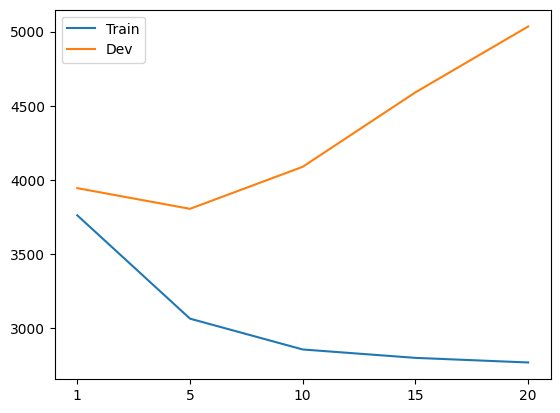

In [ ]:
ks = [1, 5, 10, 15, 20]
train_scores, dev_scores = test_models(M, ks)
# print(train_scores, dev_scores)
plt.plot(np.arange(len(train_scores)), train_scores, label="Train")
plt.plot(np.arange(len(dev_scores)), dev_scores, label="Dev")
plt.xticks(np.arange(len(ks)), [str(k) for k in ks])
plt.legend()
plt.show()

# Part 3: Visualization

In the following section, we'll be visually exploring topic modeling through a series of graphs and other visualizations of the data. **Please clear all graph outputs from your notebook before submitting; otherwise the file size will be too large for us to manually grade.**

## PCA Visualization

Now for the exciting part! Let's use perplexity graph you just made to inspect the data visually.

We should train the model with the amount of topics that minimized perplexity above for the dev set.

In [ ]:
# TODO: Train the model on the full data using the number of topics you chose above (i.e., the value of k that minimized perplexity on dev).
best_k = 5 # number of topics that got the best perplexity
topic_model = train_topic_model(term_doc_mat=M, n_topics=best_k) # train the topic model with best_k topics
topics = preview_topics(topic_model, idx2word)

To start, we want to visualize our term-document matrix, but that can be difficult to visualize because each document is represented by a 5000-component vector. Therefore, in order to visualize our matrix we'll want to use **dimensionality reduction** to reduce the number of components to 2, so that we can plot each document on a 2D grid.  

In the cell below, we'll make use of PCA (principal component analysis), a process that uses SVD (singular value decomposition) to extract the two most important "principal components" of our data. We can then use these to visualize our matrix. You will NOT need to code this function; we've already made use of `sklearn.decomposition.PCA` to do it for you. Please take the time to read and understand it, however, as you'll be using it later in the assignment.

- The output of `PCA.fit_transform()` is a matrix of shape `(n_samples, n_components)`, where `n_samples = num_documents`, and `n_components = 2` in our case. We will treat each row `i` of the output as 2D coordinates for document `i`.
- Check out the PCA documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
from sklearn.decomposition import PCA

# NOTE: This code initializes our PCA model to project our matrix M into 2 dimensions
def pca_projection(M : np.ndarray[np.float64], n_components : int = 2) -> np.ndarray[np.float64]:
    """
    Uses PCA to project M into n_components.
    Note: You do NOT need to code this function.

    Parameters
    ----------
    M : np.ndarray[float]
        The input term-document matrix
    n_components : int
        The number of components/dimensions that you want to reduce to

    Returns
    -------
    proj : np.ndarray[float]
        The projected matrix (M projected to n_components)
    """
    pca = PCA(n_components) # PCA model with n_components = 2
    proj = pca.fit_transform(M) # np.array of shape (n_samples, n_components)
    return proj


With this projection, we can now plot all of the documents on a 2D plane, but ideally we want each point to be colored by their most "prominent" topic and also contain some more identifying data about the document.

In order to achieve this, let's create a function to build a Pandas dataframe `df` such that
1. Each row corresponds to one of the documents
2. The `topic` column maps each document to its most prominent topic
3. The `text` column maps each document to a quick text snippet (the first 100 characters) from the document
4. The `x` and `y` columns map to the (x, y) coordinates of the 2D projection

To help you start, we have created an empty Pandas dataframe with the columns defined, but with no data. Please fill in this dataframe with information from `docs`. You can look up more about Pandas dataframes [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). You're free to implement this however you wish, but it might be easiest to first create a list of dictionaries and then call the `pd.DataFrame` constructor on said list.


In [ ]:
def generate_datapoints(docs : list[spacy_doc], proj: np.ndarray[np.float64], M : np.ndarray[np.float64], topic_model: LatentDirichletAllocation) -> pd.DataFrame:
    """
    Generates a Pandas dataframe where each row corresponds to the data point (document). Specifically:
        1. The (x, y) coordinates of the projected document
        2. The text of the document (capped at 100 characters)
        3. The most prominent topic of the document

    Parameters
    ----------
    docs : list[spacy_doc]
        A list of spaCy preprocessed documents
    M : np.ndarray[float]
        The input term-document matrix
    proj: np.ndarray[float]
        The projection matrix of M onto 2D space, using our previously defined pca_projection function
    topic_model: LatentDirichletAllocation
        The trained topic model

    Returns
    -------
    df : DataFrame
        The filled-out dataframe
    """
    # TODO: Fill out the dataframe df
    # HINT: To help you find the most "prominent" topic for each document, we can use our topic model to transform M so that
    #       we get a matrix of shape (num_documents, num_topic), where each entry is the "prominence" score of that topic for that document.
    # df = pd.DataFrame(columns = ["topic", "text", "x", "y"])
    df = pd.DataFrame(columns = ["topic", "text", "x", "y"])
    topic_dist = topic_model.components_
    first_100 = []
    for doc in docs:
        s = ""
        for token in doc:
            s += token.text
            if len(s) >= 100:
                break
        s = s[:min(len(s), 100)]
        first_100.append(s)
    topic_scores = topic_model.transform(M)
    r = {"topic":[], "text":[], "x":[], "y":[]}
    for i in range(topic_scores.shape[0]):
        r = {}
        topic = np.argmax(topic_scores[i])
        text = first_100[i]
        x = proj[i][0]
        y = proj[i][1]
        r["topic"] = str(topic)
        r["text"] = text
        r["x"] = x
        r["y"] = y
        df.loc[len(df)] = r
    # df = pd.DataFrame(r)
    return df

Now, run the following cell to plot the PCA projection of our documents onto 2D! Each point corresponds to a document, which you can hover over and view some of the contents of.

In [ ]:
import plotly.express as px

df = generate_datapoints(spacy_processed_docs, pca_projection(M, 2), M, topic_model)
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=['text'])
fig.show()

## Geographical Visualization

Now, we'd like you to visualize the most popular topics based on geographical location!

We'll start with a simple bar graph for each state, showing the popularity of each topic, where the height of each bar is the proportion of documents from the location that corresponds to a particular topic.

As a warning, these counts of documents are unnormalized. Because of this, states that have a lot of documents may more regularly appear at the front of the bar charts (they're ordered by frequency). These charts won't indicate which topics are proportionally popular by state, despite that being more intuitive.

To visualize the most popular topics by location, we first need to group and count the number of documents who have that topic as their most "prominent" topic and who originate from that location.

Please fill in the `generate_location_data` function, which takes in a list of documents and a corresponding list of locations, and creates a dictionary that maps each topic to a dictionary of `{location : count}`.

In [ ]:
def generate_location_data(docs : list[spacy_doc], M : np.ndarray[np.float64], locations : list[str], topic_model: LatentDirichletAllocation) -> dict[int, dict[str, int]]:
    """
    Aggregates the documents that all share the same most "prominent" topic
    and retains a count of the number of documents at each location for each topic.
    This information will later be used to generate a bar chart visualization
    and map visualization of where each topic is most popular.

    Parameters
    ----------
    docs : list[spacy_doc]
        A list of spaCy preprocessed documents
    M : np.ndarray[float]
        The input term-document matrix
    locations : list[str]
        A list that records the location of each document (location of i-th document is doc_locations[i])
    topic_model: LatentDirichletAllocation
        The trained topic model

    Returns
    -------
    location_count : dict[int, dict[str, int]]
        A dictionary that maps each topic (int) to a dictionary that in turn maps
        location (str) to count (int) for that topic (i.e., location_count[topic][state]
        is the count of documents for that state and topic)
    """
    # TODO: Fill out location_count
    # HINT: As above, you can find the most prominent topic for each document
    #       by using topic_model to transform M (see generate_datapoints above)
    # HINT: It may be helpful to start by creating a dictionary mapping topics (int)
    #       to a list of locations of the documents which have that topic as their
    #       most prominent topic
    location_count = {}
    topic_scores = topic_model.transform(M)
    for i in range(topic_scores.shape[0]):
        topic = np.argmax(topic_scores[i])
        if topic not in location_count:
            location_count[topic] = {}
        loc = locations[i]
        if loc in location_count[topic]:
            location_count[topic][loc] += 1
        else:
            location_count[topic][loc] = 1
    return location_count

With this, we can use the `generate_location_data` function to aggregate the number of locations for each topic and then generate our bar graphs. Nothing more needs to be done here!

In [ ]:
total_doc_counts = Counter(doc_locations)
state_items = sorted(total_doc_counts.items(), key = lambda item: item[1])
print(state_items)

[('Nebraska', 4), ('Vermont', 6), ('New Hampshire', 7), ('Arizona', 9), ('Michigan', 14), ('New Jersey', 16), ('Oregon', 19), ('West Virginia', 20), ('Arkansas', 22), ('Virginia', 24), ('South Carolina', 26), ('Wisconsin', 30), ('Tennessee', 31), ('Rhode Island', 31), ('Kansas', 36), ('Indiana', 39), ('Alaska', 40), ('Montana', 45), ('Iowa', 45), ('Oklahoma', 45), ('Kentucky', 56), ('Hawaii', 60), ('Utah', 65), ('Alabama', 70), ('Florida', 70), ('Connecticut', 81), ('South Dakota', 82), ('Missouri', 84), ('North Carolina', 85), ('Georgia', 92), ('North Dakota', 94), ('Mississippi', 97), ('New Mexico', 115), ('Nevada', 128), ('Louisiana', 135), ('Texas', 151), ('Illinois', 184), ('New York', 185), ('Maine', 192), ('Ohio', 211), ('Pennsylvania', 253), ('Massachusetts', 326), ('Colorado', 343), ('Washington', 357), ('Minnesota', 446), ('California', 529)]


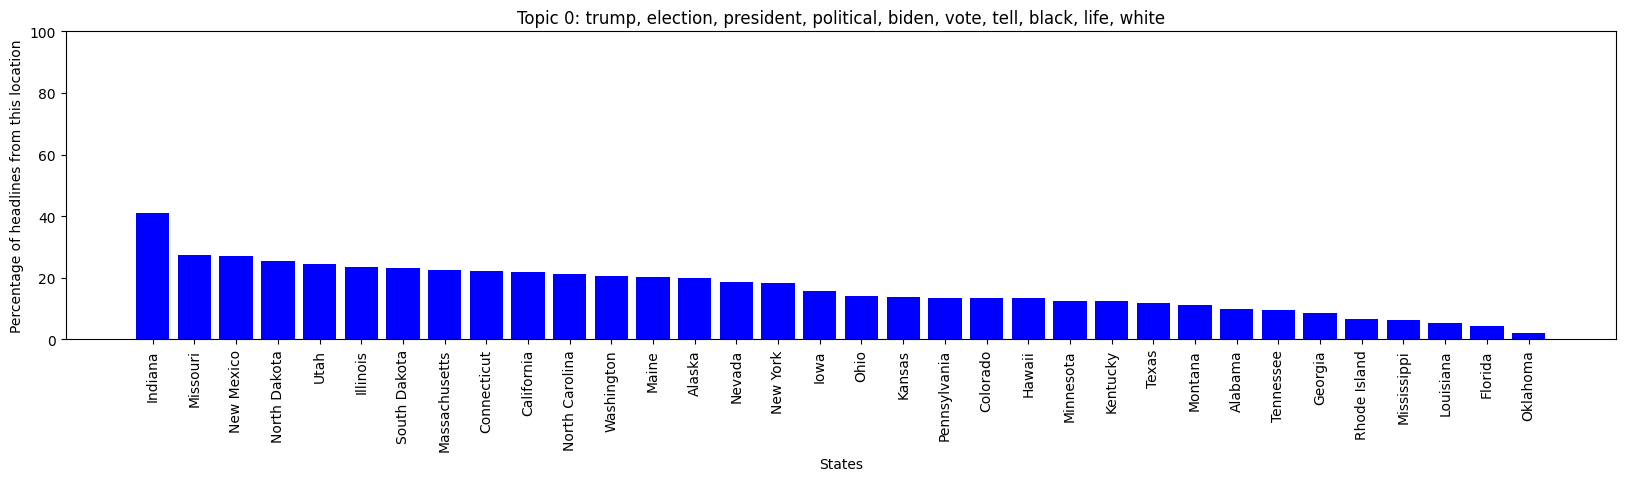

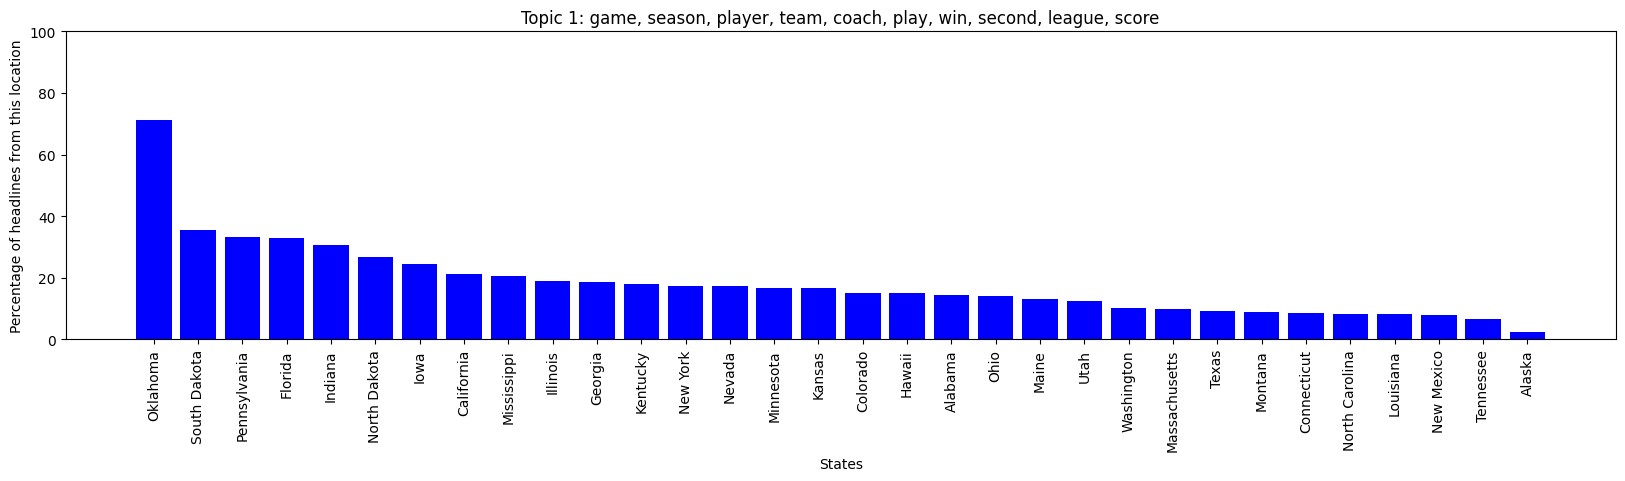

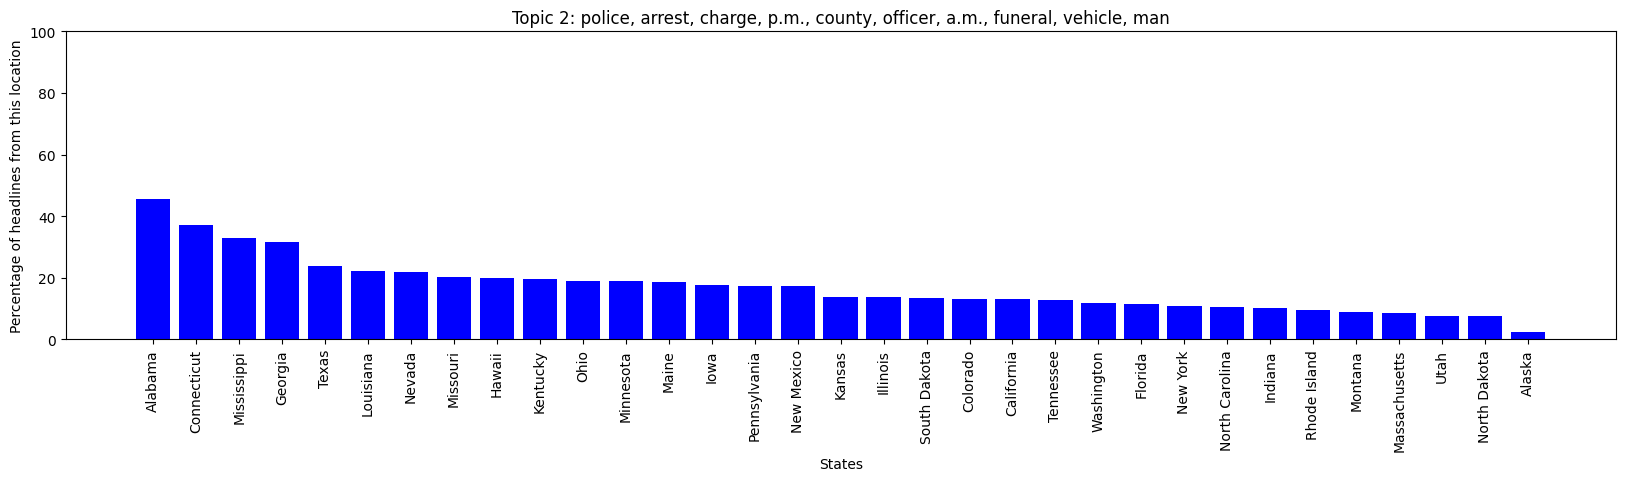

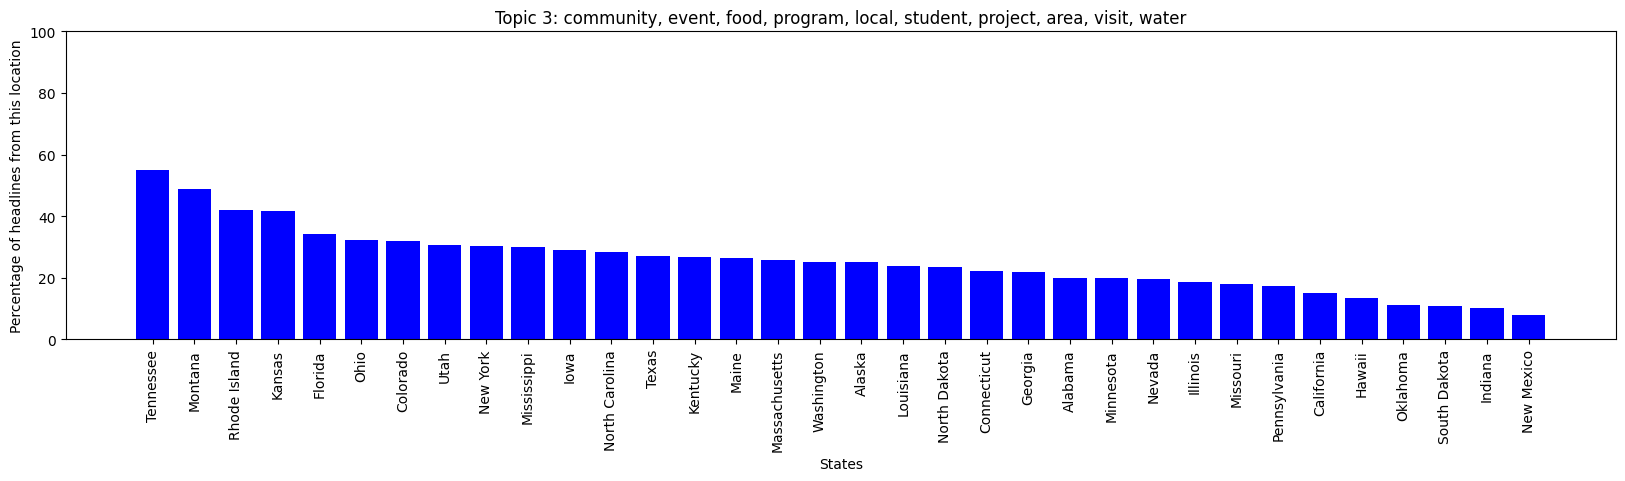

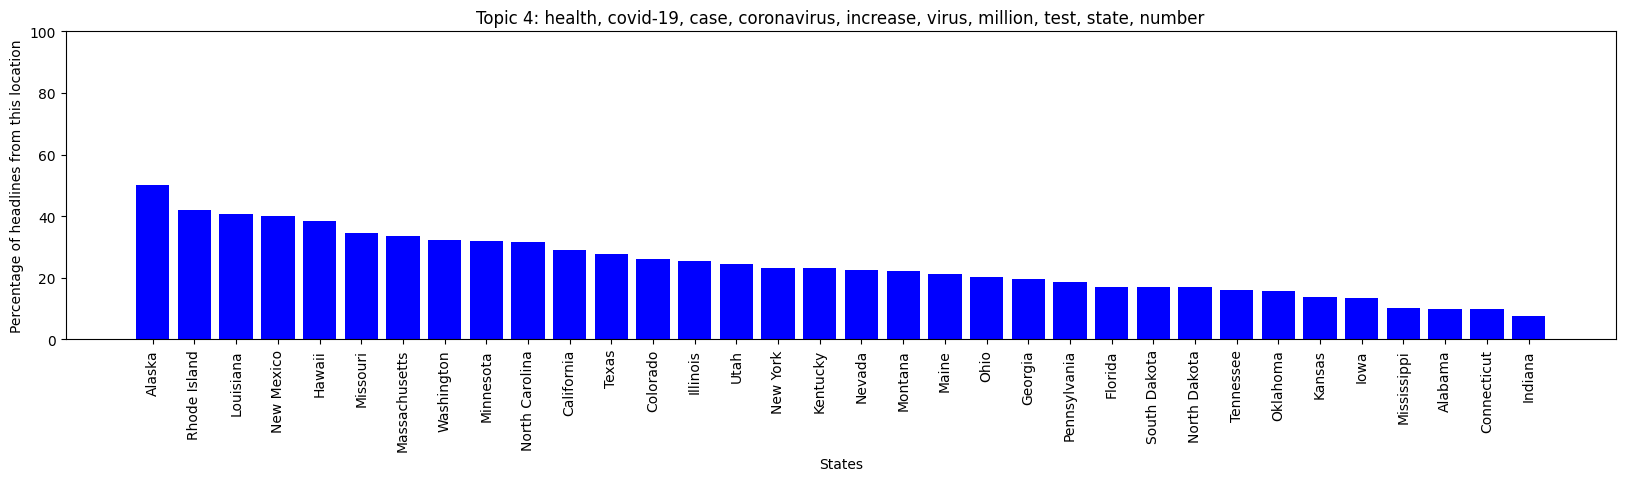

In [ ]:
state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)

# makes a bar graph displaying the popularity (as a proportion) per state
for k in range(best_k):
    fig = plt.figure(figsize=(20,4))
    threshold = 30

    total_doc_counts = dict(Counter(doc_locations).items())
    normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
    state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
    state_names = [item[0] for item in state_items]
    count = np.array([item[1] for item in state_items])

    plt.bar(state_names, count, color ='blue', width = .8)
    plt.ylim([0, 100])
    plt.xticks(rotation=90)
    plt.xlabel("States")
    plt.ylabel("Percentage of headlines from this location")
    plt.title(f"Topic {k}: {', '.join(topics[k])}")
    plt.show()

Now, we'll use a library to plot the number of documents of each topic on a map, because it's much more visually intuitive than a bar graph!

In [ ]:
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

# geolocation service
geolocator = Nominatim(user_agent='myapplication')
for k in range(best_k):
    lon, lat = [], []

    threshold = 30

    total_doc_counts = dict(Counter(doc_locations).items())
    normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
    state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
    state_names = [item[0] for item in state_items]
    count = np.array([item[1] for item in state_items])

    labels = []
    # assign each state a geographical location
    for state, c in zip(state_names, count):
        location = geolocator.geocode(state, timeout=10)
        lat.append(location.latitude)
        lon.append(location.longitude)
        labels.append(f"{state} : {c}% of all {state} headlines have this topic")

    marker = dict(color="blue", size=count)
    fig = go.Figure(data=go.Scattergeo(lon=lon, lat=lat, text=labels, mode='markers', marker=marker))
    fig.update_layout(title = f"Topic {k}: {', '.join(topics[k])}" ,geo_scope='usa')
    fig.show()

# 4. Conceptual Questions

In this section, you may need to write more code to answer the conceptual questions—much of which will draw from code you've already written above. **Do *not* change any code you've already written above**; you may make duplicates in this section to edit, if necessary. **Make sure that you are not copying functions with the same name as previous functions**, as that will break the autograder. Create markdown cells for written responses.

### Question 1: Threshold?
When we plotted the bar graphs and geographical graphs, we included a line `threshold=30` to exclude some states. Run this code cell below to re-create the bar graphs with the same topic model, this time without excluding any states.

Using one of these topics and its new top state as an example, why was the threshold necessary?



The threshold of 30 in the code was used to filter out states that had fewer than 30 documents associated with them.

> The reason this threshold was necessary is because states with very few documents could introduce noise into the visualization, leading to misleading or uninformative results. For example, in topic 0, New Hampshire have the highest percentage of headline appearance if without threshold. However, New Hampshire takes rather small share in all the documents. It just happens to appear a lot in topic 0, but saying it is representative enough for topic 0 doesn't seem to be fair.







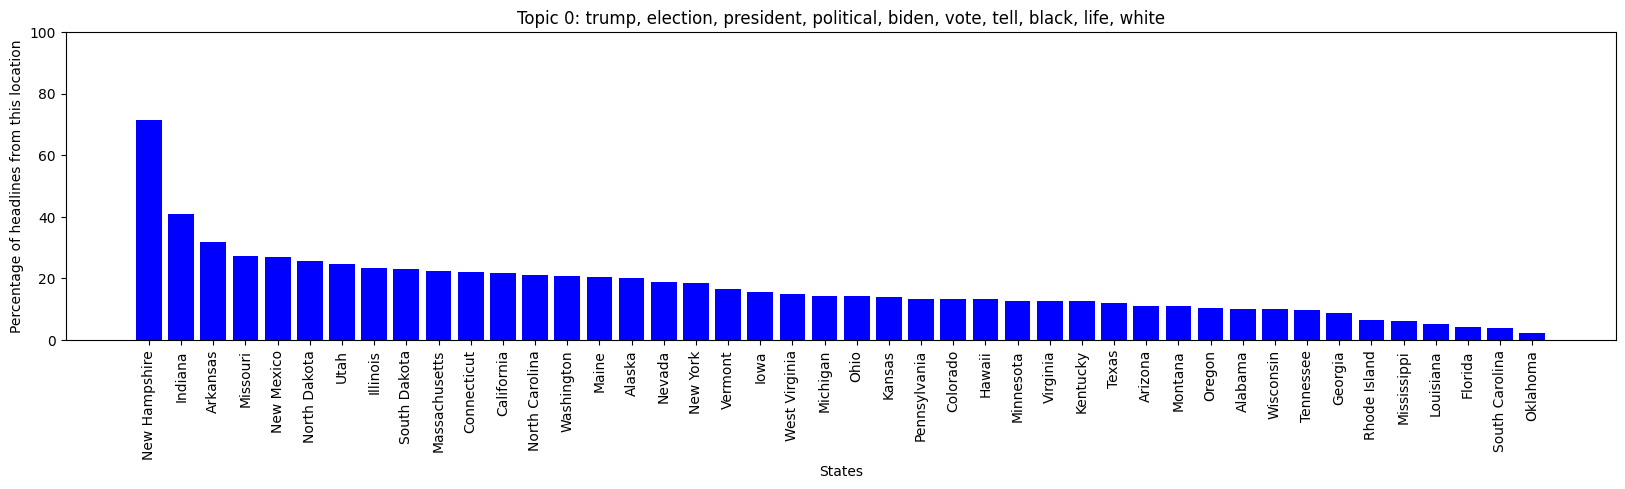

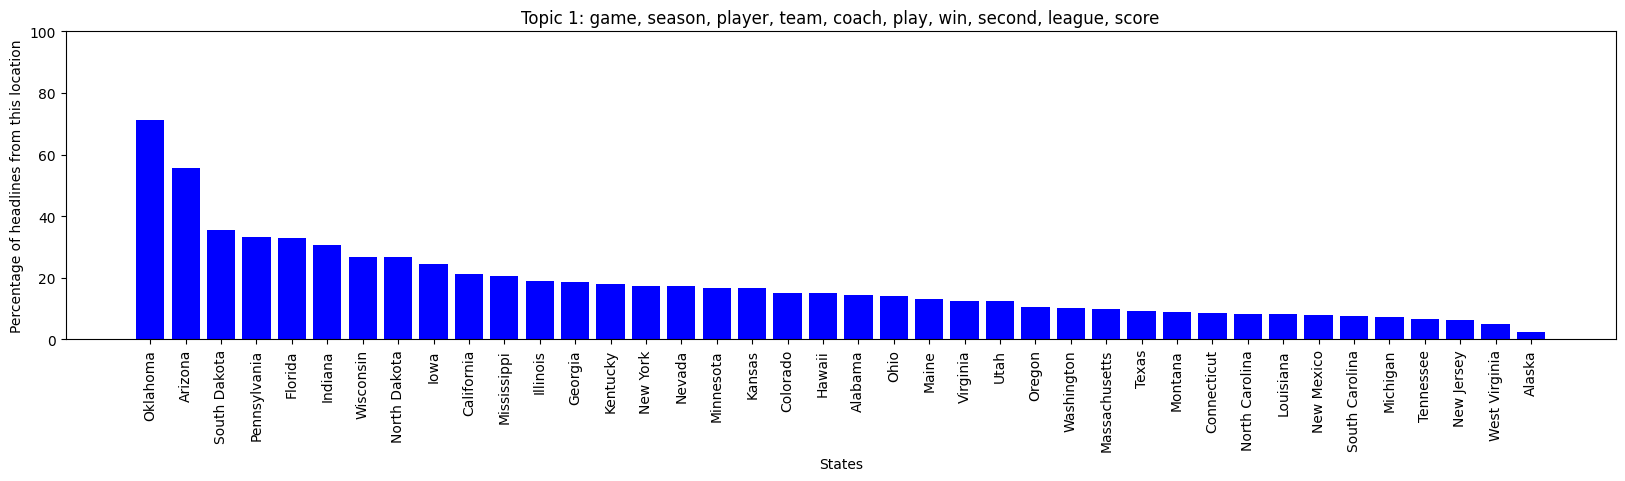

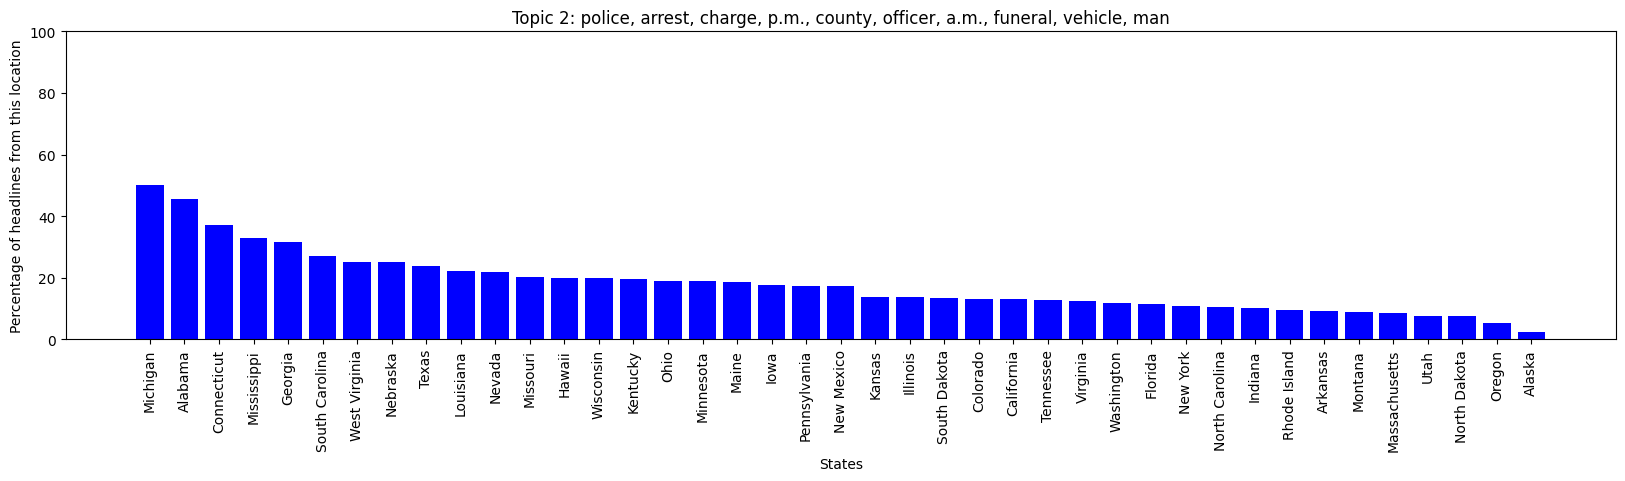

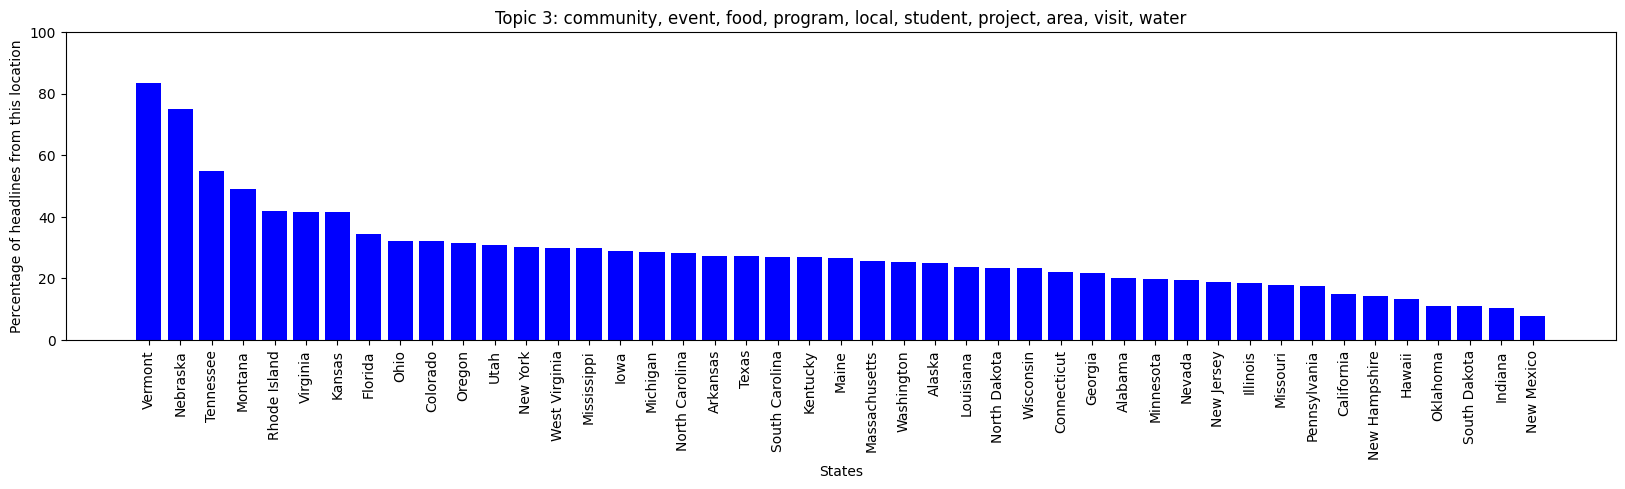

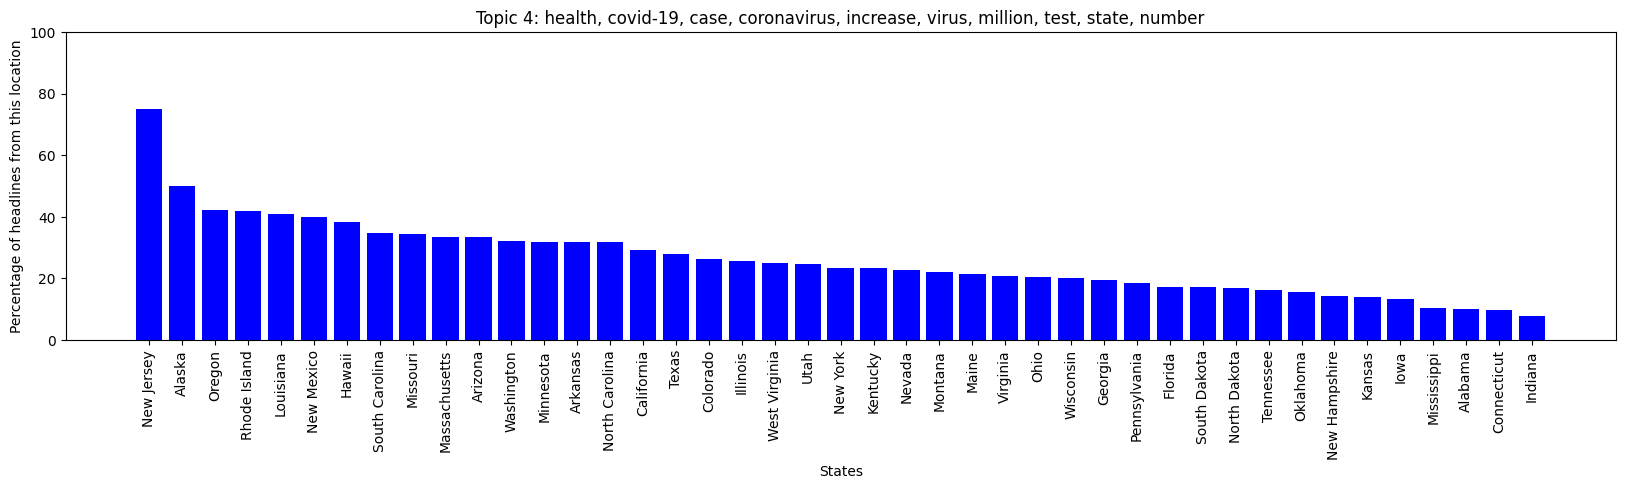

In [ ]:
state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)

for k in range(best_k):
    fig = plt.figure(figsize=(20,4))

    threshold = 0
    total_doc_counts = dict(Counter(doc_locations).items())
    normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
    state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
    state_names = [item[0] for item in state_items]
    count = np.array([item[1] for item in state_items])

    plt.bar(state_names, count, color ='blue', width = .8)
    plt.ylim([0, 100])
    plt.xticks(rotation=90)
    plt.xlabel("States")
    plt.ylabel("Percentage of headlines from this location")
    plt.title(f"Topic {k}: {', '.join(topics[k])}")
    plt.show()

### Question 2: Perplexed on Perplexity
We asked you to plot a perplexity graph to choose the number of topics that minimizes perplexity on held-out data. In order to answer the following questions, you'll need some background information on the "generative story" of LDA, a topic we normally get to but this year did not. Before answering the following questions, please watch the lecture captures from last year ([9/26/2023](https://brown.hosted.panopto.com/Panopto/Pages/Sessions/List.aspx#folderID=%22c8f2f7a9-887f-4472-9adf-b05f014ffc5f%22&page=0&maxResults=50), timestamps around 18:00-27:30 and [9/21/2023](https://brown.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=4b12e3c4-7e32-46c2-ab39-b08300d64d25), timestamps around 1:00:30-1:14:30). You can also refer to [Wikipedia's explanation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#Generative_process).
- Why does perplexity not necessarily decrease when the number of topics increases?
- In language modeling, the model maintains a distribution over words, and the perplexity is a measure of how ‘surprised’ the model is by a corpus. If the model assigns a low probability to a document, the perplexity of that document will be relatively high. What are the probability distributions that contribute to the perplexity of an LDA model?




> 1. Once a sufficient number of well-defined topics are established, further increases in the number of topics might break these fine themes into more specific/niche "subtopics". While these finer distinctions can be useful, they provide less marginal value because they capture increasingly specialized patterns that don't contribute much to improving the model's fit to unseen data. Thus, the benefit of adding new topics decreases because they no longer add significant explanatory power to the model.


> 2. **Topic Distribution for Documents** and **Word Distribution for Topics**.
Each document is assumed to be a mixture of topics. The model maintains a probability distribution over topics for each document. Each topic is associated with a probability distribution over words. The model maintains a distribution over the vocabulary for each topic.











# Submission Instructions
**Please clear any graph output from Part 3: Visualization before submitting. Do not clear the graph output from conceptual question 1.**

Please submit this Colab file as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file ***WITH OUTPUTS***: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.

Last Updated: 26 Sept 2024